# Advanced Lane Lines
---


In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt


## Camera Calibration

In [2]:
# Prepare object points
objp = np.zeros((54, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#print(objp.shape, objp)

# Arrays to store object points and image points
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

cal_path = './camera_cal/'

# Read in the calibration image names from calibration folder
images = glob.glob(cal_path + 'calibration*.jpg')

# Loop through the image to calibrate
for idx, fname in enumerate(images):
    
    # read image
    img = cv2.imread(fname)
    
    # convert to greyscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Look for chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # if found, process these points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # draw and display the corners
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        out_filename = cal_path + 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite(out_filename, img)
        
        
# load reference image
img = cv2.imread(cal_path + 'calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the calibration results
dist_pickle = {}
dist_pickle['mtx'] = mtx  # camera matrix
dist_pickle['dist'] = dist # distortion coefficient
pickle.dump(dist_pickle, open(cal_path+'calibration_pickle.p', 'wb'))



## Image Preprocessing Pipeline
---
Define a pipeline

In [3]:
# Helper functions

# functions used to thresholding the images
def color_thresh(image, sthresh=(0,255), vthresh=(0,255), lthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    l_channel = luv[:,:,2]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= lthresh[0]) & (l_channel <= lthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1) & (l_binary == 1)] = 1
    return output
    

def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        
    return binary_output


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

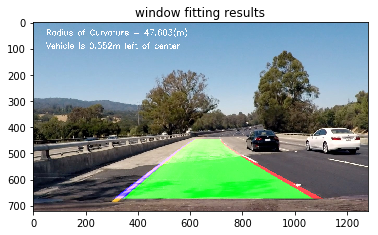

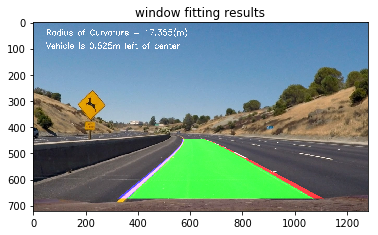

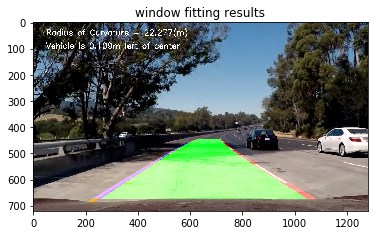

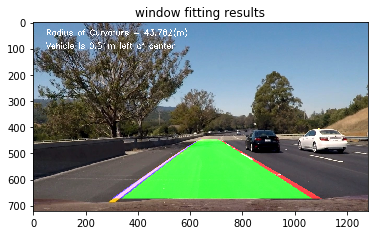

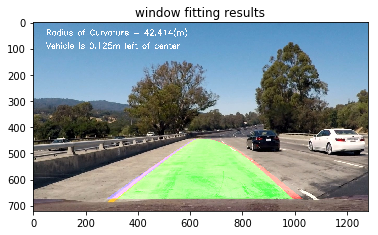

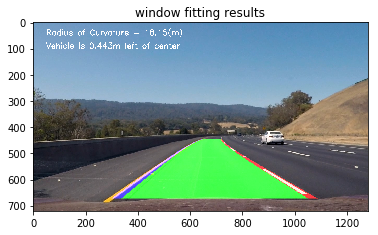

In [6]:
test_img_path = './test_images/'

# Test on some test images
images = glob.glob(test_img_path + 'test*.jpg')

for idx, fname in enumerate(images):
    # read the image
    img_bgr = cv2.imread(fname)
    
    b,g,r = cv2.split(img_bgr)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    
    #plt.imshow(img)
    
   

    # undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    preprocessedImage = np.zeros_like(img[:,:,0])
    
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12, 255))
    grady = abs_sobel_thresh(img, orient='y', thresh=(25, 255))
    c_binary = color_thresh(img, sthresh=(100, 255), vthresh=(50, 255), lthresh=(50, 255))
    
    preprocessedImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
    
    
    # work on defining perspective transformation
    img_size = (img.shape[1], img.shape[0])
    btm_width = 0.76 # percentage of bottom trapizoid height
    mid_width = 0.08 # percentage of middle trapizoid height
    height_pct = 0.62 # percentage for trapizoid height
    btm_trim = 0.935 # percentage from top to bottom to avoid car hood
    
    src = np.float32([[img.shape[1]*(0.5 - mid_width/2), img.shape[0]*height_pct], 
                      [img.shape[1]*(0.5 + mid_width/2), img.shape[0]*height_pct],
                      [img.shape[1]*(0.5 + btm_width/2), img.shape[0]*btm_trim],
                      [img.shape[1]*(0.5 - btm_width/2), img.shape[0]*btm_trim]])
    
    offset = img_size[0] * 0.2
    
    dst = np.float32([[offset, 0],
                      [img_size[0] - offset, 0],
                      [img_size[0] - offset, img_size[1]],
                      [offset, img_size[1]]])
    
    # perform perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2. getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(preprocessedImage, M, img_size, flags=cv2.INTER_LINEAR)
    
    window_width = 30
    window_height = 80
    
    # set up the Tracker object to do all the tracking
    curve_centers = Tracker(myWindowWidth = window_width, myWindowHeight = window_height, 
                            myMargin = 100, myYm = 10/720, myXm = 4/384, mySmoothFactor=5)
    
    window_centroids = curve_centers.find_window_centroids(warped)
    
    # Draw the result
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        
        # Points used to find the left and right lanes
        rightx = []
        leftx = []

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            
            # add center value found in frame to the list of lane points for left, right
            leftx.append(window_centroids[level][0])
            rightx.append(window_centroids[level][1])
            
            
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        
        # output of the sliding window result
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        
        # fit the lane boundaries to the left, right and center positions
        yvals = range(0, warped.shape[0])
        
        res_yvals = np.arange(warped.shape[0]-window_height/2, 0, -window_height)
        
        left_fit = np.polyfit(res_yvals, leftx,2)
        left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
        left_fitx = np.array(left_fitx, np.int32)
        
        right_fit = np.polyfit(res_yvals, rightx, 2)
        right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
        right_fitx = np.array(right_fitx, np.int32)
        
        left_lane = np.array(list(zip(np.concatenate((left_fitx - window_width/2, left_fitx[::-1] + window_width/2), axis=0),
                                      np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
        
        right_lane = np.array(list(zip(np.concatenate((right_fitx - window_width/2, right_fitx[::-1] + window_width/2), axis=0), 
                                       np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)
        
        middel_marker = np.array(list(zip(np.concatenate((left_fitx + window_width/2, right_fitx[::-1] - window_width/2), axis=0), 
                                          np.concatenate((yvals, yvals[::-1]), axis=0))), np.int32)

        road = np.zeros_like(img)
        road_bkg = np.zeros_like(img) # background of road

        cv2.fillPoly(road, [left_lane], color=[255,0,0])
        cv2.fillPoly(road, [right_lane], color=[0,0,255])
        cv2.fillPoly(road, [middel_marker], color=[0,255,0])
        cv2.fillPoly(road_bkg, [left_lane], color=[0,0,0])
        cv2.fillPoly(road_bkg, [right_lane], color=[0,0,0])
        
        road_warped = cv2.warpPerspective(road, Minv, img_size, flags = cv2.INTER_LINEAR)
        road_warped_bkg = cv2.warpPerspective(road_bkg, Minv, img_size, flags = cv2.INTER_LINEAR)
        
        base = cv2.addWeighted(img_bgr, 1.0, road_warped_bkg, -1.0, 0.0)
        result = cv2.addWeighted(base, 1.0, road_warped, 1.0, 0.0)
        
        ym_per_pix = curve_centers.ym_per_pix
        xm_per_pix = curve_centers.xm_per_pix
        
        curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix, 2)
        curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])

        camera_center = (left_fitx[-1] + right_fitx[-1])/2
        center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
        side_pos = 'left'
        if center_diff <= 0:
            side_pos = 'right'

        cv2.putText(result, 'Radius of Curvature = ' +str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        cv2.putText(result,'Vehicle is '+str(abs(round(center_diff,3))) +'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)


        
        
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    #plt.imshow(img)

    plt.title('window fitting results')
    plt.show()
    test_img_path = './test_images/'
    out_filename = test_img_path + 'road_fitting_warped'+str(idx)+'.jpg'
    cv2.imwrite(out_filename, result)
    


In [5]:
# defining the Tracker class for sliding window approach
class Tracker():
    
    def __init__(self, myWindowWidth, myWindowHeight, myMargin, myYm=1, myXm=1, mySmoothFactor=15):
        # list that stores all the past (left, right) center set values for smoothing the output
        self.recent_centers = []
        # window pixel width of the center values, used to count pixels inside center windows to determine curve values
        self.windowWidth = myWindowWidth
        # window pixel height of the center values, used to count pixels inside center windows to determine curve values
        self.windowHeight = myWindowHeight
        # pixel distance in both directions to slide (left_window + right_window) template for searching
        self.margin = myMargin
        # meters per pixel in vertical direction
        self.ym_per_pix = myYm 
        # meters per pixel in horizontal direction
        self.xm_per_pix = myXm
        self.smooth_factor = mySmoothFactor
    
    
    def find_window_centroids(self, warped):
        window_width = self.windowWidth
        window_height = self.windowHeight
        margin = self.margin
        
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))
        
        self.recent_centers.append(window_centroids)
        
        return np.average(self.recent_centers[-self.smooth_factor:], axis=0)